# Studies of data reuse: Excitability profile of CA1 pyramidal neurons in APPPS1 Alzheimer disease mice and control littermates (v1)

In this notebook we will look more closely at the EBRAINS dataset "[Excitability profile of CA1 pyramidal neurons in APPPS1 Alzheimer disease mice and control littermates (v1)](https://search.kg.ebrains.eu/?category=Dataset&modality[0]=electrophysiology&dataAccessibility[0]=free%20access#bd5f91ff-e829-4b85-92eb-fc56991541f1)", contributed by Hélène Marie from the Université Côte d’Azur in Valbonne, France.

As we can see from the dataset description,

<i>This dataset provides an analysis of the intrinsic electrophysiological properties of CA1 excitatory hippocampal
neurons in a mouse model of Alzheimer’s Disease (AD) at two age points: a presymptomatic age (3-4
months) and a symptomatic age: (9-10 months).</i>
More information is available in the [Data Descriptor](https://search.kg.ebrains.eu/instances/bd5f91ff-e829-4b85-92eb-fc56991541f1).

This dataset forms part of the results reported in Vitale, P., Salgueiro-Pereira, A. R., Lupascu, C. A., Willem, M., Migliore, R., Migliore, M., & Marie, H.(2021) Analysis of Age-Dependent Alterations in Excitability Properties of CA1 Pyramidal Neurons in an APPPS1 Model of Alzheimer’s Disease. *Frontiers in Aging Neuroscience* **13** https://doi.org/10.3389/fnagi.2021.668948

In this notebook we will demonstrate how to access the data files and the metadata from this study, and how these data can be analysed and visualised, with the goal of reproducing some of the figures from the article. 

## Downloading the data and metadata

TODO - use fairgraph


## Exploring and visualizing the data

The data are organized into four folders, "APPPS1_mouse_model_3-4_months", "control_3-4_months", "APPPS1_mouse_model_9-10_months", "control_9-10_months", each of which contains a number of files with the extension ".abf".

It should be noted that the dataset does not contain the data for mice at age 1 month that are shown in the associated paper (Vitale et al., 2021).

We know from the dataset metadata that these are electrophysiology data, and more specifically that they were obtained with the whole cell patch clamp technique in current clamp mode. We will therefore use the [Neo library](https://neo.readthedocs.io/) to read the data files, since it is able to read data from a large number of electrophysiology file formats.

In [8]:
from glob import glob
import numpy as np
from neo import get_io

Neo loads data into a hierarchical structure: Blocks contain Segments, which contain the actual data.

Let's look at the structure of the first three files:

In [20]:
for file_path in glob("ext-d000001_ADNeuronModel_pub/*/*.abf")[:3]:
    io = get_io(file_path)
    print(io)

AxonIO: ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129007_rita_S23.abf
nb_block: 1
nb_segment:  [13]
signal_streams: [Signals (chans: 1)]
signal_channels: [IN0]
spike_channels: []
event_channels: [Tag]

AxonIO: ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129006_rita_S23.abf
nb_block: 1
nb_segment:  [13]
signal_streams: [Signals (chans: 1)]
signal_channels: [IN0]
spike_channels: []
event_channels: [Tag]

AxonIO: ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191202006_rita_S22.abf
nb_block: 1
nb_segment:  [13]
signal_streams: [Signals (chans: 1)]
signal_channels: [IN0]
spike_channels: []
event_channels: [Tag]



These all have a consistent structure: they're in Axon format, contain a single block containing 13 segments, and each segment contains a single recorded signal containing a single channel. 
We know from the associated paper that current pulses of increasing intensity were injected into the neurons, in steps of 50 pA from -200 to 400 pA.

In [13]:
current_pulse_amplitudes = np.arange(-200, 401, 50)  # we set the upper limit above 400, so that the final value is 400
print(current_pulse_amplitudes)
print(f"Number of current pulses: {len(current_pulse_amplitudes)}")

[-200 -150 -100  -50    0   50  100  150  200  250  300  350  400]
Number of current pulses: 13


So it seems likely that each segment contains the response to one current pulse. We will assume at this point that all the signals are similar, and take a closer look at one of them.

In [22]:
data = get_io("ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129000_S23.abf").read(lazy=True)
example_signal = data[0].segments[0].analogsignals[0].load()
example_signal

AnalogSignal with 1 channels of length 50000; units mV; datatype float32 
name: 'Signals'
annotations: {'stream_id': '0'}
sampling rate: 10000.0 Hz
time: 0.020999999999999998 s to 5.021 s

Now let's plot the data from one of the files:

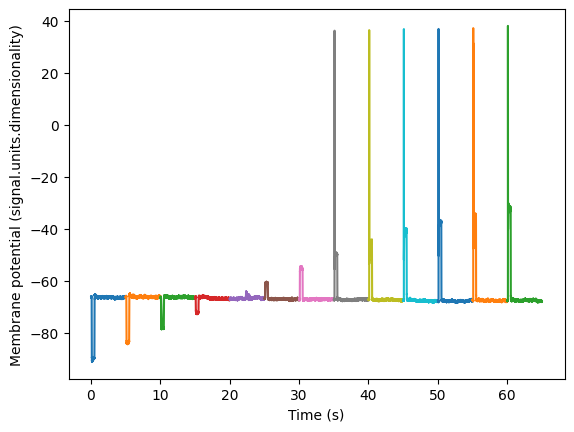

In [36]:
import matplotlib.pyplot as plt

def plot_data(file_path):
    data = get_io(file_path).read(lazy=True)
    for segment in data[0].segments:
        signal = segment.analogsignals[0].load()
        plt.plot(signal.times, signal)
    plt.xlabel(f"Time ({signal.times.units.dimensionality})")
    plt.ylabel(f"Membrane potential (signal.units.dimensionality)")

plot_data("ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129000_S23.abf")

To get a closer look at the signals, we can shift the time axis to be relative to the start time of each signal, and plot only the 500 ms around the current injection:

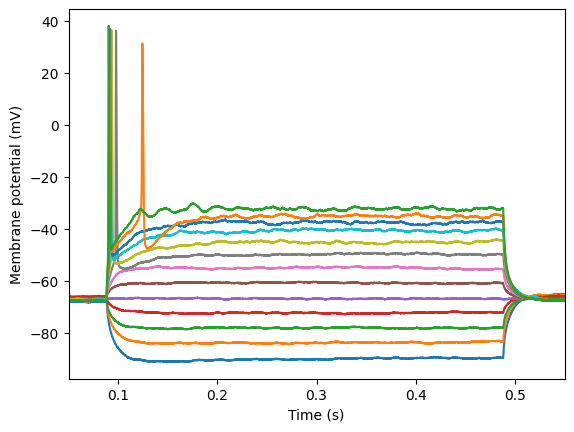

In [49]:
def plot_data_zoom(file_path):
    data = get_io(file_path).read(lazy=True)
    for segment in data[0].segments:
        signal = segment.analogsignals[0].load()
        plt.plot(signal.times - signal.t_start, signal)
    plt.xlim(0.05, 0.55)
    plt.xlabel(f"Time ({signal.times.units.dimensionality})")
    plt.ylabel(f"Membrane potential ({signal.units.dimensionality})")

plot_data_zoom("ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129000_S23.abf")

### Figure 2

Figure 2A shows the input resistance calculated from the native resting membrane potential (RMP) of the neuron (i.e. the resting membrane potential before a holding current is injected to bring it to -65 mV), and Figure 2B shows the native RMP.

The files in the dataset only contain data recorded while the holding current is being injected, so we cannot reproduce panels 2A and 2B.

The remainder of Figure 2 show calculations of the membrane time constant, based on the responses to current injection. To obtain the membrane time constant, we can use the [eFEL](https://efel.readthedocs.io/) library.

In [67]:
import efel

def get_time_constants(signals):
    # for eFEL, we need to convert the Neo signal into a plain NumPy array with time units of milliseconds
    traces = [{
        'T': (signal.times - signal.t_start).rescale("ms").magnitude, 
        'V': signal.magnitude.flatten(),
        'stim_start': [50], 
        'stim_end': [550]} for signal in signals]
    feature_values = efel.getFeatureValues(traces, ['time_constant'])
    # the response is a list of dicts, now we convert this into a single array
    return np.hstack([val["time_constant"] for val in feature_values])


condition_data = {
    "WT-4m": "control_3-4_months",
    "AD-4m": "APPPS1_mouse_model_3-4_months",
    "WT-10m": "control_9-10_months",
    "AD-10m": "APPPS1_mouse_model_9-10_months",
}

time_constants = {}
for condition_label, data_folder in condition_data.items():
    time_constants[condition_label] = {}
    for injected_current in (-200, -150, -100, -50):
        signals = []
        for file_path in glob(f"ext-d000001_ADNeuronModel_pub/{data_folder}/*.abf"):
            data = get_io(file_path).read(lazy=True)
            i = list(current_pulse_amplitudes).index(injected_current)
            signals.append(data[0].segments[i].analogsignals[0].load())

        time_constants[condition_label][injected_current] = get_time_constants(signals)

time_constants

{'WT-4m': {-200: array([19.1928464 , 15.83026989, 18.78930236, 30.79387241, 17.65217371,
         11.25997063, 14.45989471, 12.94064848, 13.18097254, 17.30221954,
         12.21351795, 10.36157401, 13.79824687]),
  -150: array([15.75834584, 19.06343749, 16.3771721 , 30.40140532, 15.58520453,
         12.49690104, 16.83168944, 24.17829038, 14.29761343, 23.92863782,
         20.06378339, 13.9672234 , 16.83944554]),
  -100: array([16.43631913, 21.89891692, 29.90384766, 22.42675618, 31.39368169,
         14.48151661, 16.14102936, 17.71920186, 14.28185411, 26.71813989,
         19.38993011, 12.03490268, 28.38110126]),
  -50: array([48.69832449, 45.17498621, 19.18961448, 22.60098267, 21.29267668,
         27.84736668, 20.88077351, 36.63799424, 16.06264653, 24.34954886,
         22.96679837, 14.4098969 , 17.25960481])},
 'AD-4m': {-200: array([13.13220028, 14.68060608, 16.06474423, 18.88862641, 14.6262633 ,
         17.17822872, 10.767798  , 17.33881535, 17.26165992, 18.74385925,
         15.

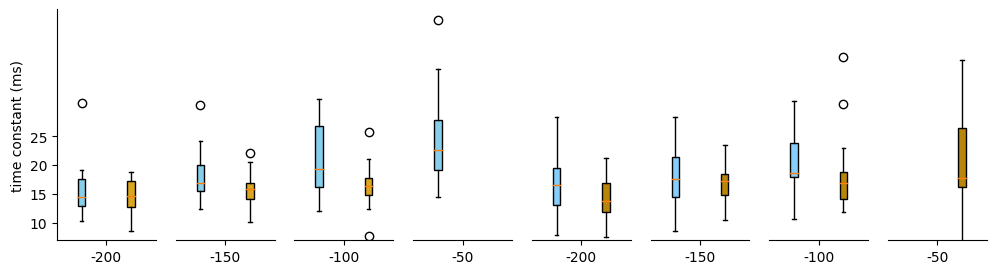

In [113]:
### Fig 2E

currents = (-200, -150, -100, -50)
data = {
    "4m": [
        (time_constants["WT-4m"][current], time_constants["AD-4m"][current])
        for current in currents
    ],
    "10m": [
        (time_constants["WT-10m"][current], time_constants["AD-10m"][current])
        for current in currents
    ]
}

colors = [("skyblue", "goldenrod"), ("lightskyblue", "darkgoldenrod")]
fig, axes = plt.subplots(1, 2 * len(currents), figsize=(12, 3))
for i, age in enumerate(("4m", "10m")):
    for j, (ax, data_item) in enumerate(zip(axes[4 * i: 4 * i + 4], data[age])):
        current = currents[j]
        bplot = ax.boxplot(data_item, patch_artist=True, labels=[f"WT-{age}", f"AD-{age}"])
        for patch, color in zip(bplot['boxes'], colors[i]):
            patch.set_facecolor(color)
        #ax.set_ylim(7, 27)
        ax.set_ylim(7, 47)
        ax.set_xticks([1.5], labels=[str(current)])
        if current == -200 and age == "4m":
                ax.set_yticks([10, 15, 20, 25])
                ax.set_ylabel("time constant (ms)")
                for spine in ("top", "right"):
                    ax.spines[spine].set_visible(False)
        else:
            ax.set_yticks([])
            for spine in ("top", "right", "left"):
                ax.spines[spine].set_visible(False)

[Original Figure 2E for comparison (CC-BY licence; see the introduction to this notebook for the citation and links to the original article)]

![fig2e](original_fig2E.png "Original Figure 2E")                                                                               

### Figure 3B
Comparison between model (colored) and experimental (gray) traces under Control and AD conditions for 1, 3–4, and 9–10 months,

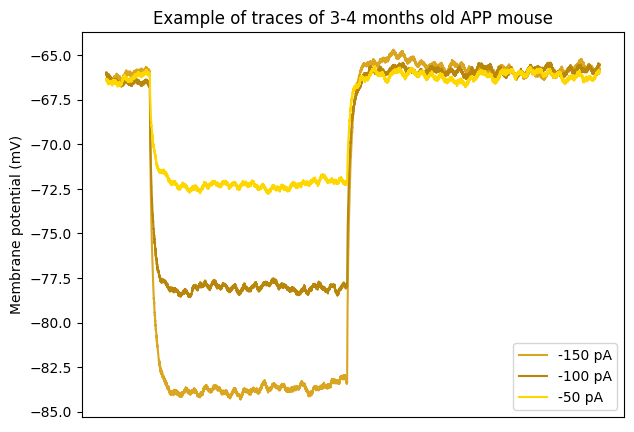

In [19]:
plt.rcParams["figure.figsize"] = (7, 5)
file_path = ("ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129000_S23.abf")
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[(1)]
channel1 = seg0.analogsignals[0]
channel1 = channel1.load()
channel1.array_annotations = {}
plt.plot(channel1.times[:10000], channel1[:10000], label=f"-150 pA",c='goldenrod')
file_path = ("ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129000_S23.abf")
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[(2)]
channel2 = seg0.analogsignals[0]
channel2 = channel2.load()
channel2.array_annotations = {}
plt.plot(channel1.times[:10000], channel2[:10000], label=f"-100 pA",c='darkgoldenrod')
file_path = ("ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129000_S23.abf")
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[(3)]
channel3 = seg0.analogsignals[0]
channel3 = channel3.load()
channel3.array_annotations = {}
plt.plot(channel1.times[:10000], channel3[:10000], label=f"-50 pA",c='gold')
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.title("Example of traces of 3-4 months old APP mouse")
frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)


### Figure 3D
Comparison between model (colored) and experimental (gray) traces under Control and AD conditions for 1, 3–4, and 9–10 months

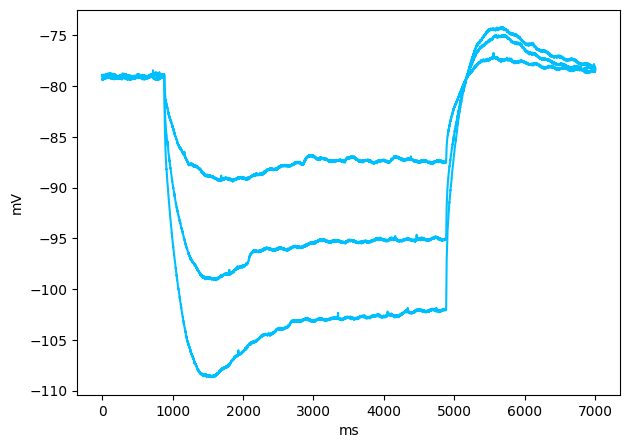

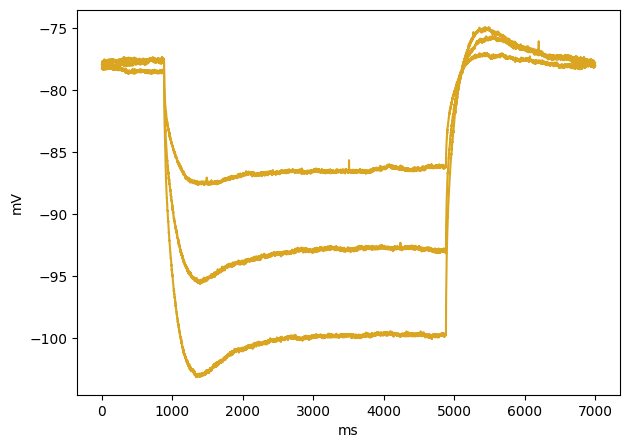

In [22]:
iris = np.genfromtxt("ext-d000001_ADNeuronModel_pub/Vitale2021_modelDB/trace_WT10m_50.txt")
import pandas as pd
df = pd.DataFrame(iris, columns = ['Column_A','Column_B'])
plt.plot(df['Column_B'],c='deepskyblue')
iris = np.genfromtxt("ext-d000001_ADNeuronModel_pub/Vitale2021_modelDB/trace_WT10m_100.txt")
df = pd.DataFrame(iris, columns = ['Column_A','Column_B1'])
plt.plot(df['Column_B1'],c='deepskyblue')
iris = np.genfromtxt("ext-d000001_ADNeuronModel_pub/Vitale2021_modelDB/trace_WT10m_150.txt")
df = pd.DataFrame(iris, columns = ['Column_A','Column_B2'])
plt.plot(df['Column_B2'],c='deepskyblue')
plt.ylabel('mV')
plt.xlabel('ms')
plt.show()


iris = np.genfromtxt("ext-d000001_ADNeuronModel_pub/Vitale2021_modelDB/trace_AD10m_50.txt")
import pandas as pd
df = pd.DataFrame(iris, columns = ['Column_A','Column_B'])
plt.plot(df['Column_B'],c='goldenrod')
iris = np.genfromtxt("ext-d000001_ADNeuronModel_pub/Vitale2021_modelDB/trace_AD10m_100.txt")
df = pd.DataFrame(iris, columns = ['Column_A','Column_B1'])
plt.plot(df['Column_B1'],c='goldenrod')
iris = np.genfromtxt("ext-d000001_ADNeuronModel_pub/Vitale2021_modelDB/trace_AD10m_150.txt")
df = pd.DataFrame(iris, columns = ['Column_A','Column_B2'])
plt.plot(df['Column_B2'],c='goldenrod')
plt.ylabel('mV')
plt.xlabel('ms')
plt.show()


### Figure 5a
Overlap of typical traces for the different conditions.

<function matplotlib.pyplot.show(close=None, block=None)>

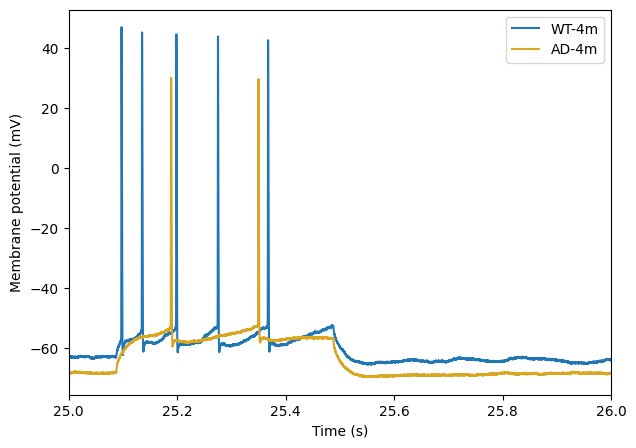

In [23]:
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/control_3-4_months/191129002_rita_S24.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[5]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="WT-4m")
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.xlim(25,26)
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191129007_rita_S23.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[5]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="AD-4m", c='goldenrod')
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.xlim(25,26)
plt.show

(55.05, 55.5)

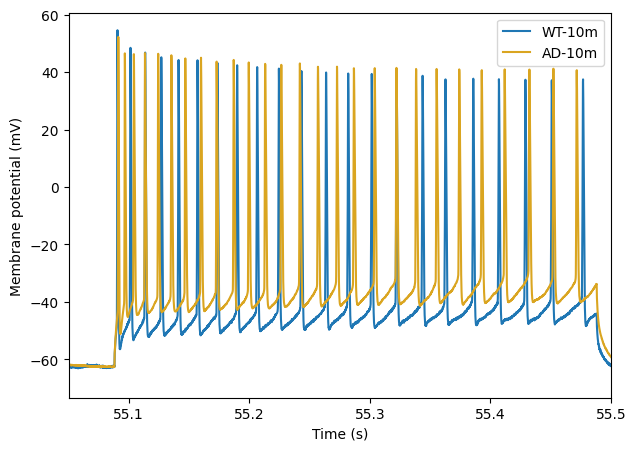

In [24]:
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/control_9-10_months/191121004_rita_S76.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[11]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="WT-10m")
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_9-10_months/200120007_S87.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[11]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="AD-10m",c='goldenrod')
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.xlim(55.05,55.5)

### Figure 6a
Enlargement of the traces to illustrate first 11 spikes in typical experimental traces at 300 pA for each age, under Control and AD conditions.

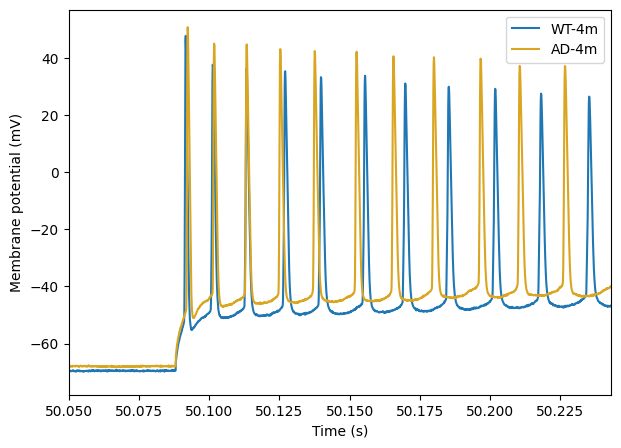

In [27]:
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_3-4_months/191202009_rita_S22.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[10]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="WT-4m")
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()

plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/control_3-4_months/191129005_rita_S24.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[10]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="AD-4m",c='goldenrod')
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.xlim(50.05,50.243)
plt.show()

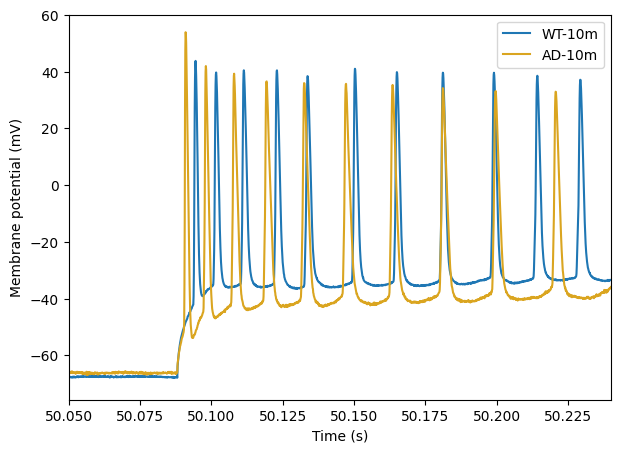

In [28]:
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/APPPS1_mouse_model_9-10_months/191122000_rita_S77.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[10]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="WT-10m")
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.rcParams["figure.figsize"] = (7, 5)
file_path = "ext-d000001_ADNeuronModel_pub/control_9-10_months/191121000_rita_S76.abf"
reader = get_io(file_path)
data = reader.read(lazy=True)
reader = get_io(file_path)
data = reader.read(lazy=True)
seg0 = data[0].segments[10]
channel0 = seg0.analogsignals[0]
channel0 = channel0.load()
channel0.array_annotations = {}
plt.plot(channel0.times, channel0, label="AD-10m",c='goldenrod')
plt.xlabel(f"Time ({channel0.times.units.dimensionality.string})")
plt.ylabel(f"Membrane potential ({channel0.units.dimensionality.string})")
plt.legend()
plt.xlim(50.05,50.24)
plt.show()